In [2]:
pip install praat-parselmouth


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 60.5 MB/s eta 0:00:00


In [7]:
# q_1

import librosa
import librosa.display as display
import scipy.signal as signal
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import parselmouth
from scipy.interpolate import interp1d

def trim_silence(y, threshold):
    # Trim the beginning and ending silence
    y_trimmed, _ = librosa.effects.trim(y, top_db=threshold)
    return y_trimmed

def downsample_method1(y):
    # This method takes every even sample
    # From 32kHz to 16kHz
    return y[::2]

def downsample_method2(y, sr, new_sr):
    return signal.resample(y, sr//new_sr * len(y))

def draw_pitch(pitch, ax, n_frames):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    # Create interpolation function
    f = interp1d(pitch.xs(), pitch_values, kind='linear', fill_value='extrapolate')
    # Interpolate pitch values to match spectrogram frames
    new_xs = np.linspace(pitch.xmin, pitch.xmax, n_frames)
    intepulated_pitch_values = f(new_xs)
    # Plot pitch contour
    ax.plot(new_xs, intepulated_pitch_values, color='r', linewidth=2)

def plot_wave(y, sr, ax):
    display.waveshow(y, sr=sr, ax=ax)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude')

def plot_spectrogram(y, S, sr, n_fft, hop_length, ax):
    # Spectrogram
    ###
    """
    # for this error:
    <ipython-input-37-dc13b87ff4df>:54: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded.
    To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
    S_db_mel = librosa.amplitude_to_db(S_mel, ref=np.max)
    S_magnitude = np.abs(S)
    """
    ###
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    # S_db = librosa.amplitude_to_db(S, ref=np.max)
    # Pitch contour using Praat
    snd = parselmouth.Sound(y.T, sampling_frequency=sr)
    pitch = snd.to_pitch()
    draw_pitch(pitch, ax, n_frames=sr//hop_length)
    # Add labels to axises
    display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', ax=ax)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')

def draw_mel_spectrogram(y, S, sr, n_fft, hop_length, ax):
    # Mel spectrogram
    S_mel = librosa.feature.melspectrogram(S=S, sr=sr, n_fft=n_fft, hop_length=hop_length)
    S_db_mel = librosa.amplitude_to_db(S_mel, ref=np.max)
    display.specshow(S_db_mel, sr=sr, hop_length=hop_length, x_axis= 'time', y_axis='mel', ax=ax)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')

def draw_energy_rms(y, sr, n_fft, hop_length, ax):

    # Energy and RMS
    frame_length = n_fft
    rms = np.array([
        np.sqrt(
            (1 / frame_length) * sum(y[i:i + frame_length] ** 2)
        )
        for i in range(0, len(y), hop_length)
    ])
    energy = np.array([
    sum(abs(y[i:i+frame_length]**2))
    for i in range(0, len(y), hop_length)
                                    ])

    # normalize
    energy = energy / np.max(energy)
    rms = rms / np.max(rms)
    # Calculate time in seconds
    frame_times = np.arange(len(rms)) * hop_length / sr

    # Plotting
    ax.plot(frame_times, rms, label='RMS')
    ax.plot(frame_times, energy, label='Energy')

    # Labels
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Normalized Amplitude')

    # Legend
    ax.legend()


def plot_spectrogram_and_save(y, sr, n_fft, hop_length, filename):
    S = librosa.stft(y, n_fft=n_fft, win_length=n_fft, hop_length=hop_length)
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_spectrogram(y, S, sr, n_fft, hop_length, ax)
    plt.savefig(filename)
    plt.close()

def multi_plot(y, sr, path):
    """
    1. D
    Assuming it is already loaded with librosa.
    """
    window_size = 0.020  # 20ms window (in seconds)
    hop_size = 0.010     # 10ms hop (in seconds)
    n_fft = int(sr * window_size)
    hop_length = int(sr * hop_size)
    fig, ax = plt.subplots(nrows=4, figsize=(20, 10))
    # Audio
    plot_wave(y, sr, ax[0])
    # Spectrogram
    S = librosa.stft(y, n_fft=n_fft, win_length=n_fft, hop_length=hop_length)
    plot_spectrogram(y, S, sr, n_fft, hop_length, ax[1])
    plot_spectrogram_and_save(y, sr, n_fft, hop_length, path)
    # Mel spectrogram
    draw_mel_spectrogram(y, S, sr, n_fft, hop_length, ax[2])
    # Energy and RMS
    draw_energy_rms(y, sr, n_fft, hop_length, ax[3])
    plt.show()


def q_1B(y, sr, path):
    new_sr = 32000
    y = signal.resample(y, num=sr//new_sr*len(y))
    sf.write(path, y, new_sr)

def q_1C(y, sr, path):
    new_sr = 16000
    y = downsample_method1(y)
    sf.write(path + '_even.wav', y, new_sr)
    y = downsample_method2(y, sr, new_sr)
    sf.write(path + '_resample.wav', y, new_sr)

def q_1D(y, sr):
    y = y.astype(np.float32)
    multi_plot(y, sr)
    # The missing timeframes in the pitch contour
    # is because there is no voice in that timeframe

def main():
    sr = 44100
    # Load the audio files
    y1, _ = librosa.load('20CM.wav', sr=sr)
    y2, _ = librosa.load('3M.wav', sr=sr)
    # Trim the silence and update y2
    y2 = trim_silence(y2, 20)
    sf.write('3M_trimmed.wav', y2, sr)
    # 1.B
    q_1B(y1, sr, '20CM_32k.wav')
    q_1B(y2, sr, '3M_trimmed_32k.wav')
    # 1.C
    y3, _ = librosa.load('20CM_32k.wav', sr=sr)
    y4, _ = librosa.load('3M_trimmed_32k.wav', sr=sr)
    samples_to_remove = 4 * sr  # trim 4 seconds
    samples_to_remove2 = 2 * sr  # trim 2 seconds

    # Trim the last 4 seconds from the audio
    y4 = y4[:-samples_to_remove]
    y4 = y4[samples_to_remove2:]
    q_1C(y3, 32000, '20CM_16K')
    q_1C(y4, 32000, '3M_trimmed_16k')

if __name__ == '__main__':
    main()

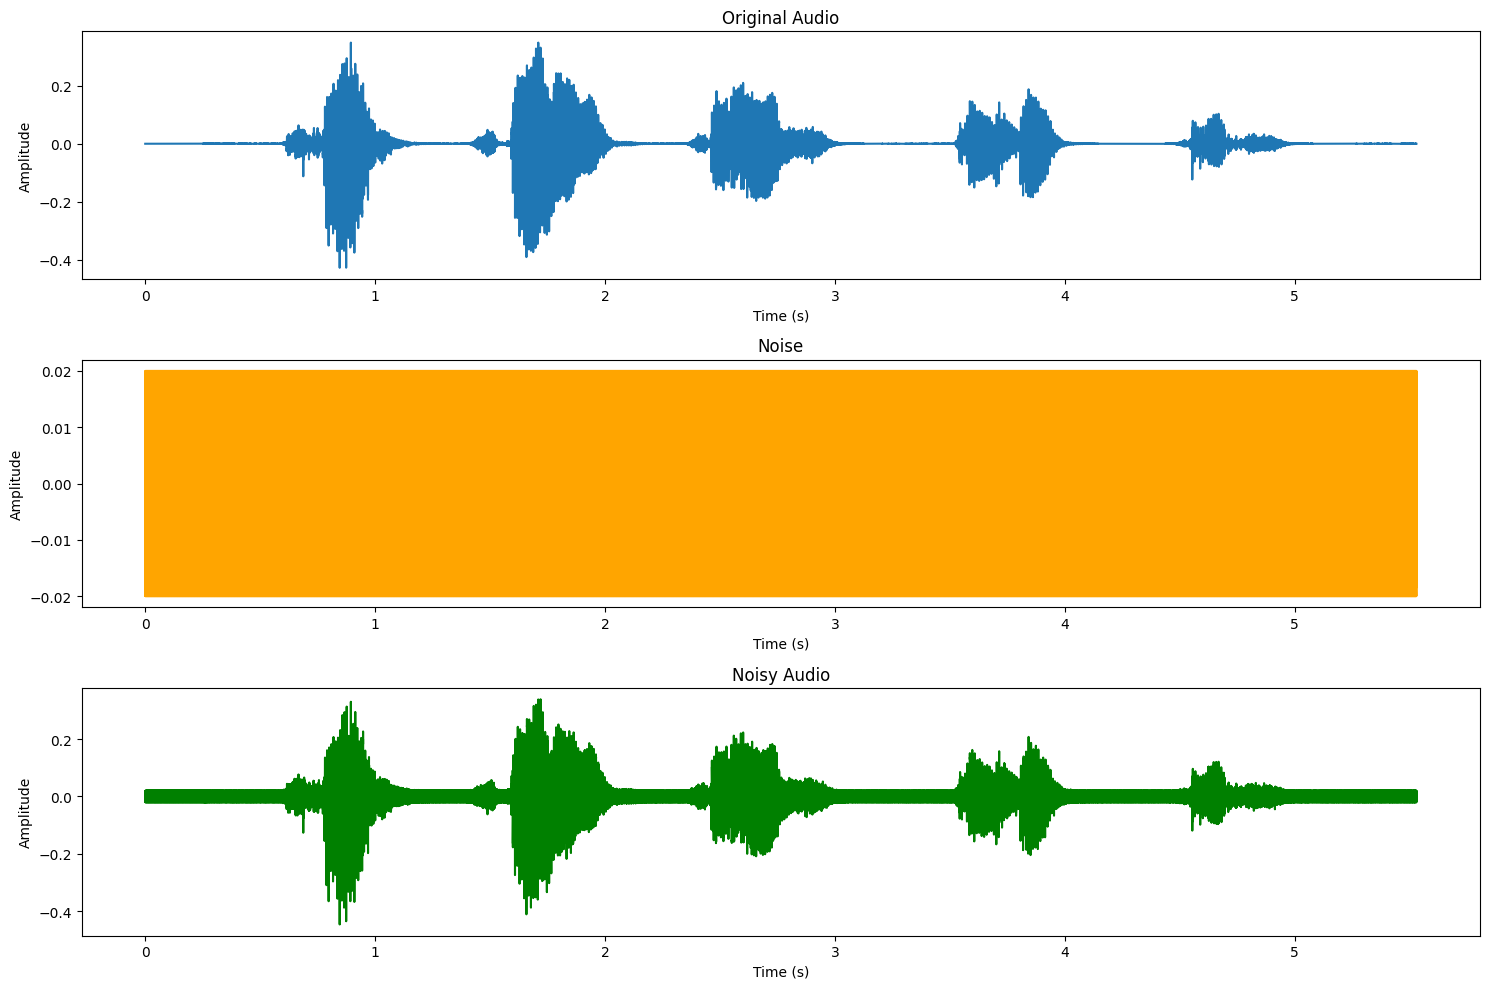

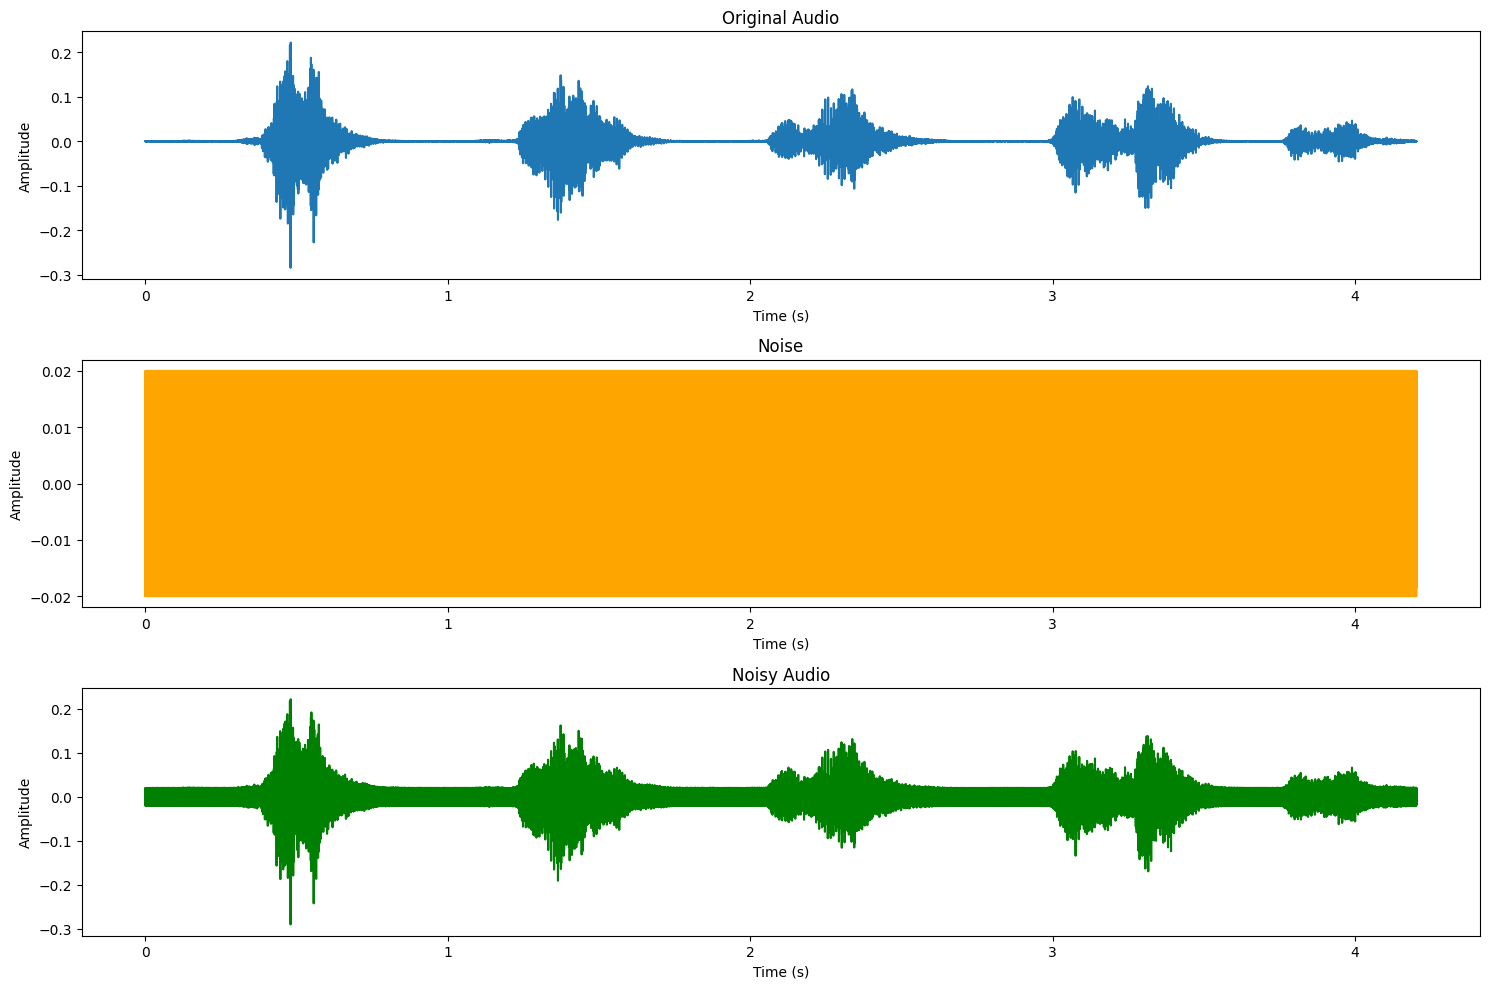

In [8]:
# q_2

import librosa
import librosa.display as display
import scipy.signal as signal
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import parselmouth
from scipy.interpolate import interp1d

sr = 32000
# Load the stationary_noise.wav audio file
stationary_noise, _ = librosa.load('stationary_noise.wav', sr=sr)
stationary_noise_resampled = downsample_method1(stationary_noise)

# Load files from Q1.c.2
y5, _ = librosa.load('20CM_16k_resample.wav', sr=16000)
y6, _ = librosa.load('3M_trimmed_16k_resample.wav', sr=16000)
# Add the noise to the audio from Q1.c.2 using ‘+’ operator
def q2_b(audio, noise, path):
  if len(audio) <= len(noise):
    # make noise shorter
    stationary_noise_resampled = noise[:len(audio)]
  else:
    # make noise longer
    stationary_noise_resampled = np.tile(noise, (len(audio) // len(noise) + 1))[:len(audio)]
  noisy_audio = audio + stationary_noise_resampled
  sf.write('noisy_' + path, noisy_audio, 16000)
  return [stationary_noise_resampled, noisy_audio]

stationary_noise_resampled_for_20CM, noisy_audio_20CM_resample = q2_b(y5, stationary_noise_resampled, '20CM_16K_resample.wav')
stationary_noise_resampled_for_3M, noisy_audio_3M_resample = q2_b(y6, stationary_noise_resampled, '3M_trimmed_16k_resample.wav')

# Plot the audio, noise, and noisy audio signals
def q2_c(audio, noise, noisy_audio, filename):

  N = len(audio)
  t = np.linspace(0, N / 16000, num=N)

  plt.figure(figsize=[15, 10])

  plt.subplot(3, 1, 1)
  plt.plot(t, audio, label="Original Audio")
  plt.title("Original Audio")
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")

  plt.subplot(3, 1, 2)
  plt.plot(t[:len(noise)], noise, label="Noise", color='orange')
  plt.title("Noise")
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")

  plt.subplot(3, 1, 3)
  plt.plot(t, noisy_audio, label="Noisy Audio", color='green')
  plt.title("Noisy Audio")
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")

  plt.tight_layout()
  plt.savefig(filename)
  plt.show()


q2_c(y5, stationary_noise_resampled_for_20CM, noisy_audio_20CM_resample, 'plot_q2_c_20CM_resmaple')
q2_c(y6, stationary_noise_resampled_for_3M, noisy_audio_3M_resample, 'plot_q2_c_plot_3M_resmaple')


<ipython-input-6-339f3f81f825>:64: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  S_db_mel = librosa.amplitude_to_db(S_mel, ref=np.max)


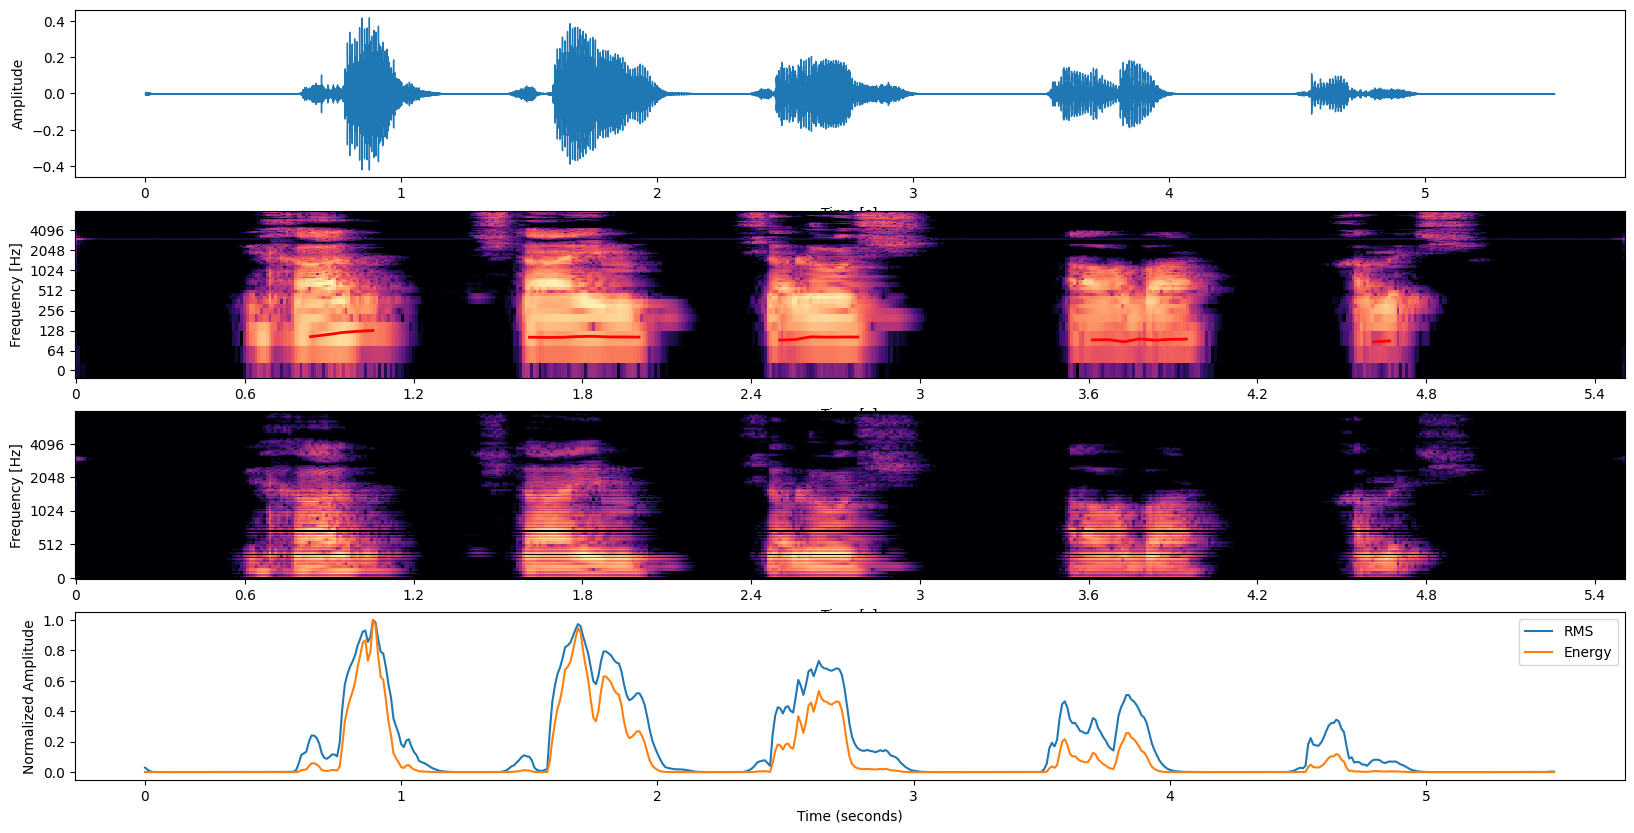

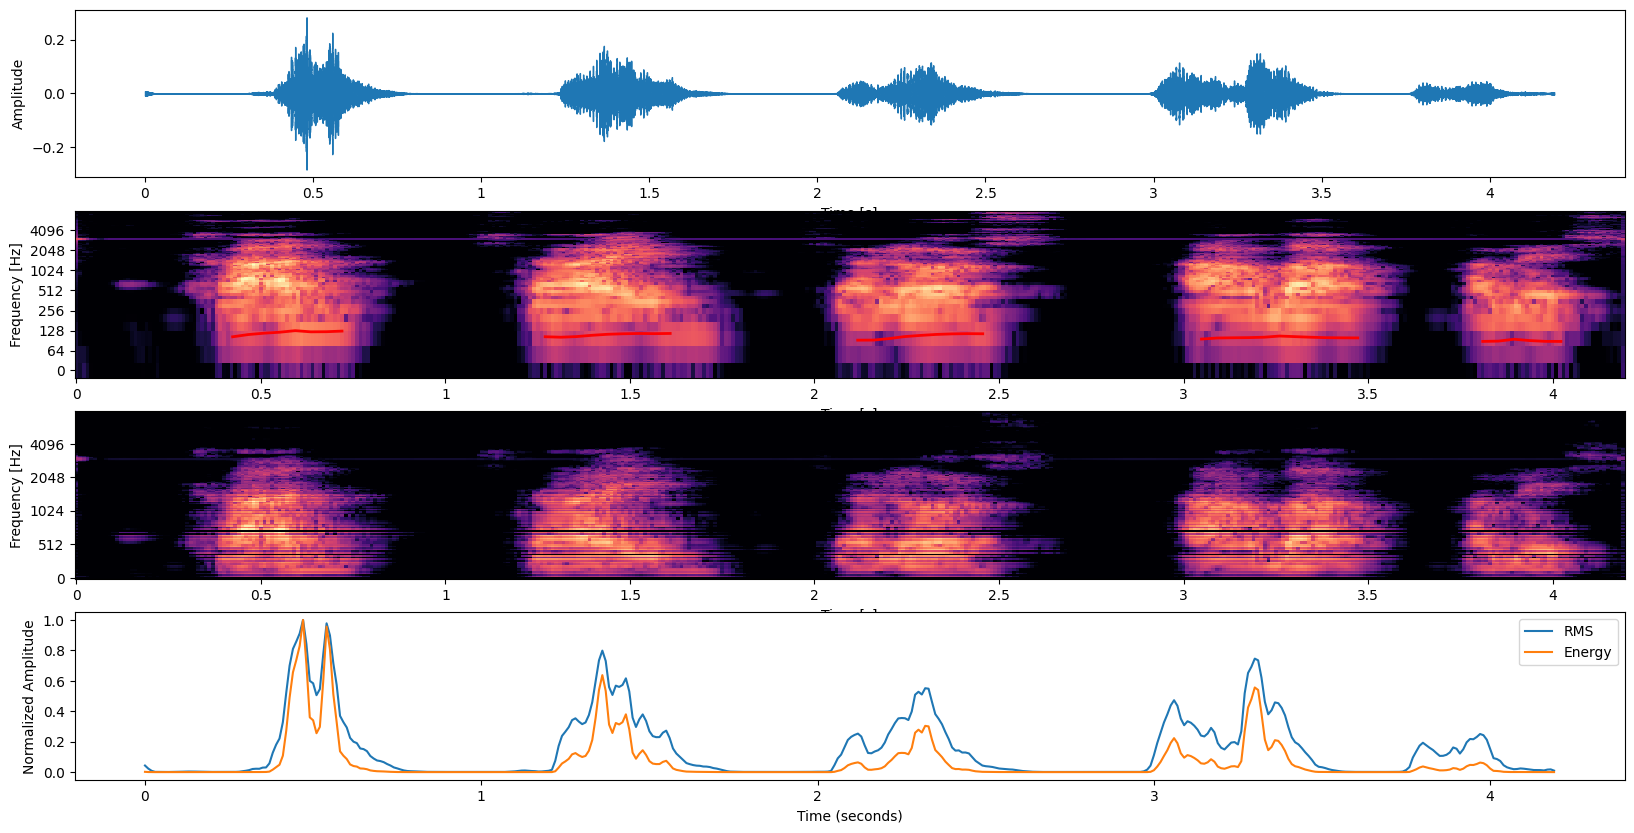

In [ ]:
# q_3

import librosa
import librosa.display as display
import scipy.signal as signal
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import parselmouth
from scipy.interpolate import interp1d

# Implement and apply spectral subtraction to enhance the noisy signal from Q2.b

sr = 16000

# Load noisy signal from Q2.b

noisy_signal_20CM, _ = librosa.load('noisy_20CM_16K_resample.wav', sr=sr)
noisy_signal_3M, _ = librosa.load('noisy_3M_trimmed_16k_resample.wav', sr=sr)

def spectral_subtraction(noisy_audio, sr, voice_activity, frame_length=2048, hop_length=512):

    # For every time-frame, find its noise estimation (‘noise footprint’)
    # and subtract it from the signal
    # Apply this in a sequential manner

    noisy_stft = librosa.stft(noisy_audio, n_fft=frame_length, hop_length=hop_length)
    non_speech_frames = np.where(voice_activity == False)[0]
    if len(non_speech_frames) > 0:
        noise_estimation = np.mean(np.abs(noisy_stft[:, non_speech_frames]), axis=1, keepdims=True)
    else:
        noise_estimation = np.min(np.abs(noisy_stft), axis=1, keepdims=True)

    noisy_stft_enhanced = np.maximum(np.abs(noisy_stft) - noise_estimation, 0) * np.exp(1j * np.angle(noisy_stft))
    enhanced_audio = librosa.istft(noisy_stft_enhanced, hop_length=hop_length)

    return enhanced_audio

def energy_calc_spectral_subtraction(noisy_audio, sr, path, energy_threshold):

    # Find the speech parts (voice activity detection) using a threshold on the energy level
    # Set up the threshold and plot its value over the energy contour

    frame_length = 2048
    hop_length = 512

    energy = np.array([np.sum(np.abs(librosa.stft(noisy_audio[i:i + frame_length], n_fft=frame_length, hop_length=hop_length))**2)
        for i in range(0, len(noisy_audio) - frame_length, hop_length)])

    normalized_energy = energy / np.max(energy)
    voice_activity = normalized_energy > energy_threshold
    enhanced_signal = spectral_subtraction(noisy_audio, sr, voice_activity, frame_length, hop_length)
    sf.write(path, enhanced_signal, 16000)

    return enhanced_signal, voice_activity, normalized_energy

removed_noise_signal_20CM, voice_activity_20CM, energy_20CM = energy_calc_spectral_subtraction(noisy_signal_20CM, sr, 'removed_noise_signal_20CM.wav', 0.035)
removed_noise_signal_3M, voice_activity_3M, energy_3M = energy_calc_spectral_subtraction(noisy_signal_3M, sr,'removed_noise_signal_3M.wav', 0.04)

# Plot the output using the function from Q1.d

multi_plot(removed_noise_signal_20CM, 16000, 'plot_q3_removed_noise_signal_20CM')
multi_plot(removed_noise_signal_3M, 16000, 'plot_q3_removed_noise_signal_3M')




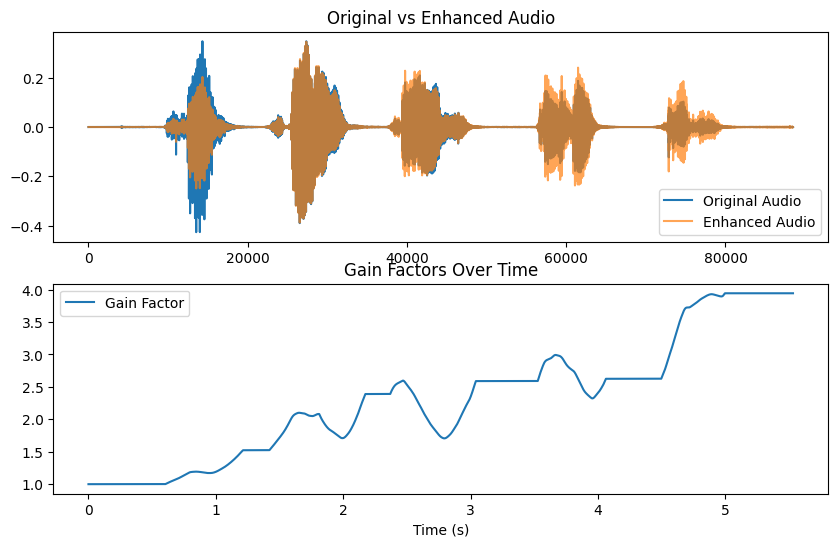

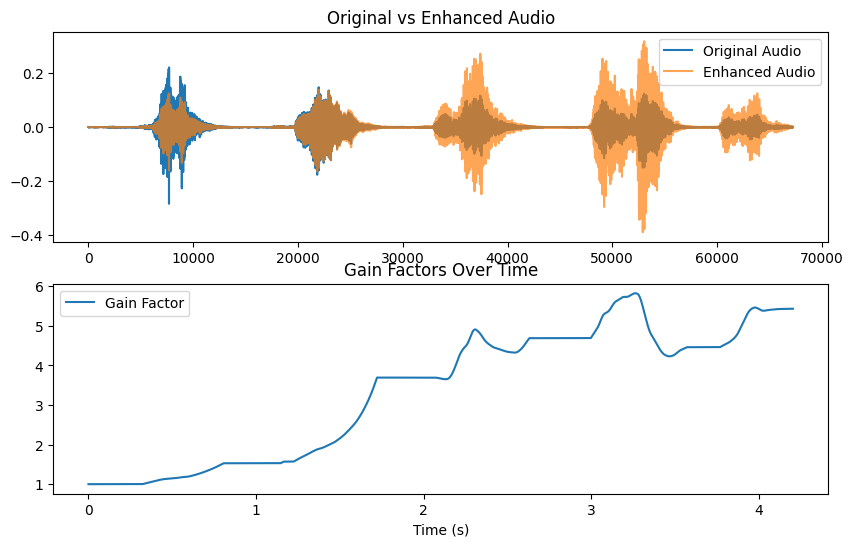

array([-3.0517578e-05, -9.1552734e-05, -7.6293945e-05, ...,
        1.4088620e-03,  1.4917362e-03,  9.1161695e-04], dtype=float32)

In [ ]:
# q_4

import numpy as np
import librosa
import matplotlib.pyplot as plt
from collections import deque
from scipy.signal import lfilter



# Apply Auto Gain Control (AGC) on the audio from Q1.c.2

sr = 16000

# Load files from Q1.c.2
y5, _ = librosa.load('20CM_16k_resample.wav', sr=16000)
y6, _ = librosa.load('3M_trimmed_16k_resample.wav', sr=16000)

# i. Determine the desired RMS in dB
# ii. Determine the noise floor threshold

def q4(audio, sr, path, plot_path, target_dB=-20, noise_floor_dB=-60, rms_window_size=0.025, agc_window_len=16000):

    # For every time-frame, find its relevant gain and amplify/attenuate
    # accordingly (using statistics based on a window of ~1s)
    # Apply this in a sequential manner
    target_rms = librosa.db_to_amplitude(target_dB)
    noise_floor = librosa.db_to_amplitude(noise_floor_dB)
    rms_track = deque([target_rms] * agc_window_len, maxlen=agc_window_len)
    gain_factors = []

    # Calculate frame length and hop length for RMS calculation
    frame_length = int(rms_window_size * sr)
    hop_length = frame_length // 2  # 50% overlap
    rms = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]
    rms_times = librosa.frames_to_time(range(len(rms)), sr=sr, hop_length=hop_length, n_fft=frame_length)
    continuous_rms = np.interp(np.arange(len(audio)), rms_times * sr, rms, left=None, right=None)

    # Process each sample
    enhanced_audio = np.zeros_like(audio)
    for i, sample in enumerate(audio):
        # Update RMS tracking
        current_rms = continuous_rms[i]
        if current_rms > noise_floor:
            rms_track.popleft()  # Remove oldest RMS value
            rms_track.append(current_rms)  # Add new RMS value

        current_gain_dB = target_dB - 20 * np.log10(np.mean(rms_track))
        current_gain = librosa.db_to_amplitude(current_gain_dB)
        gain_factors.append(current_gain)

        # Make sure you don’t have overflow in the audio after amplifying.
        enhanced_audio[i] = 2 / (1 + np.exp(-sample * current_gain)) - 1

    sf.write(path, enhanced_audio, 16000)
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(audio, label='Original Audio')
    plt.plot(enhanced_audio, label='Enhanced Audio', alpha=0.7)
    plt.legend()
    plt.title('Original vs Enhanced Audio')

    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(audio)) / sr, gain_factors, label='Gain Factor')
    plt.legend()
    plt.title('Gain Factors Over Time')
    plt.xlabel('Time (s)')
    plt.savefig(plot_path)
    plt.show()

    return enhanced_audio
q4(y5, sr, 'AGC_20CM_16K_resample.wav', 'plot_q4_AGC_20CM_16K_resample.png')
q4(y6, sr, 'AGC_3M_16K_resample.wav', 'plot_q4_AGC_3M_16K_resample.png')



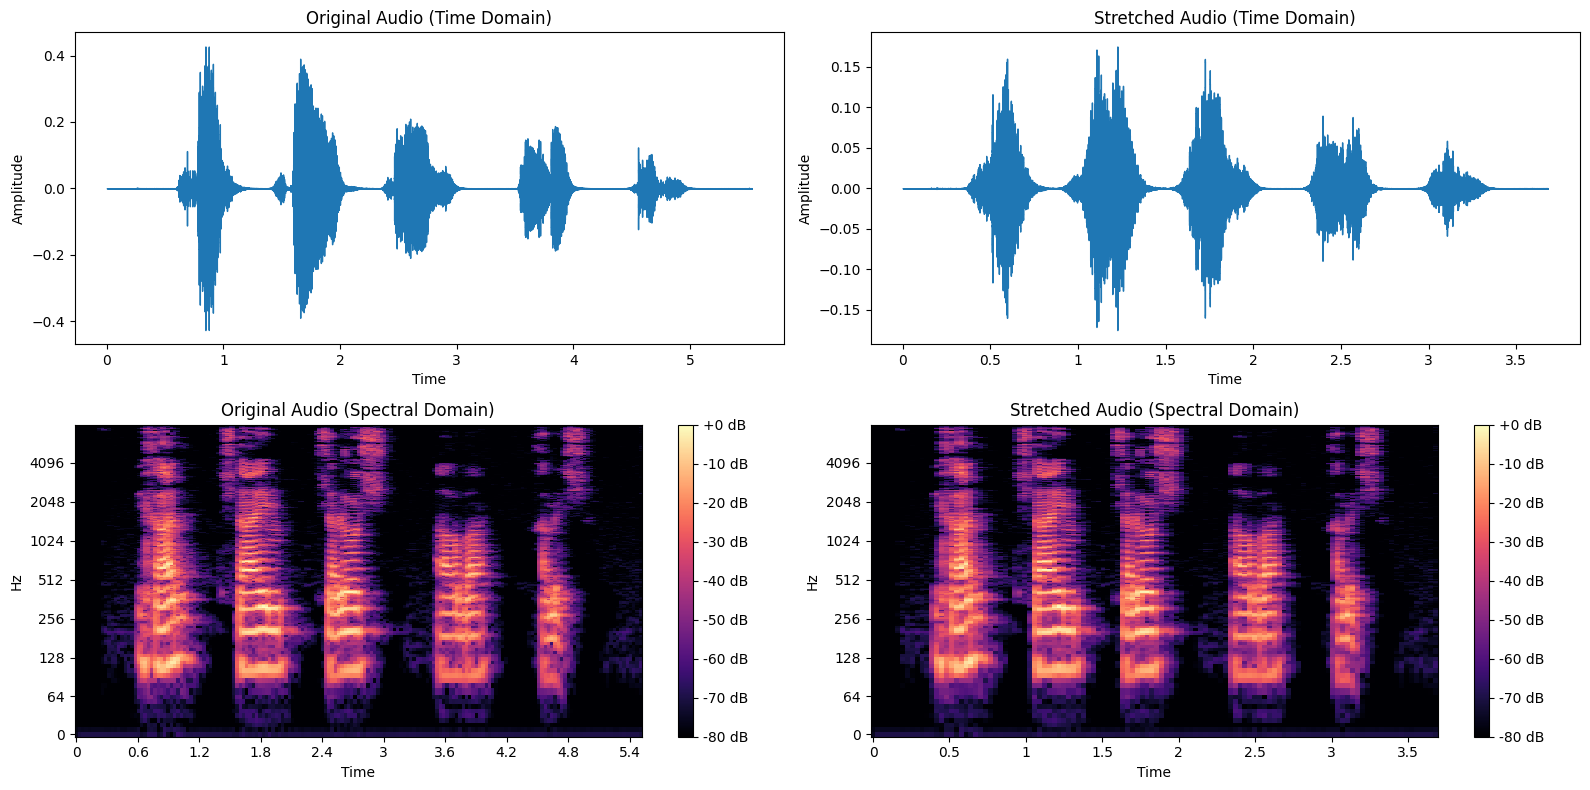

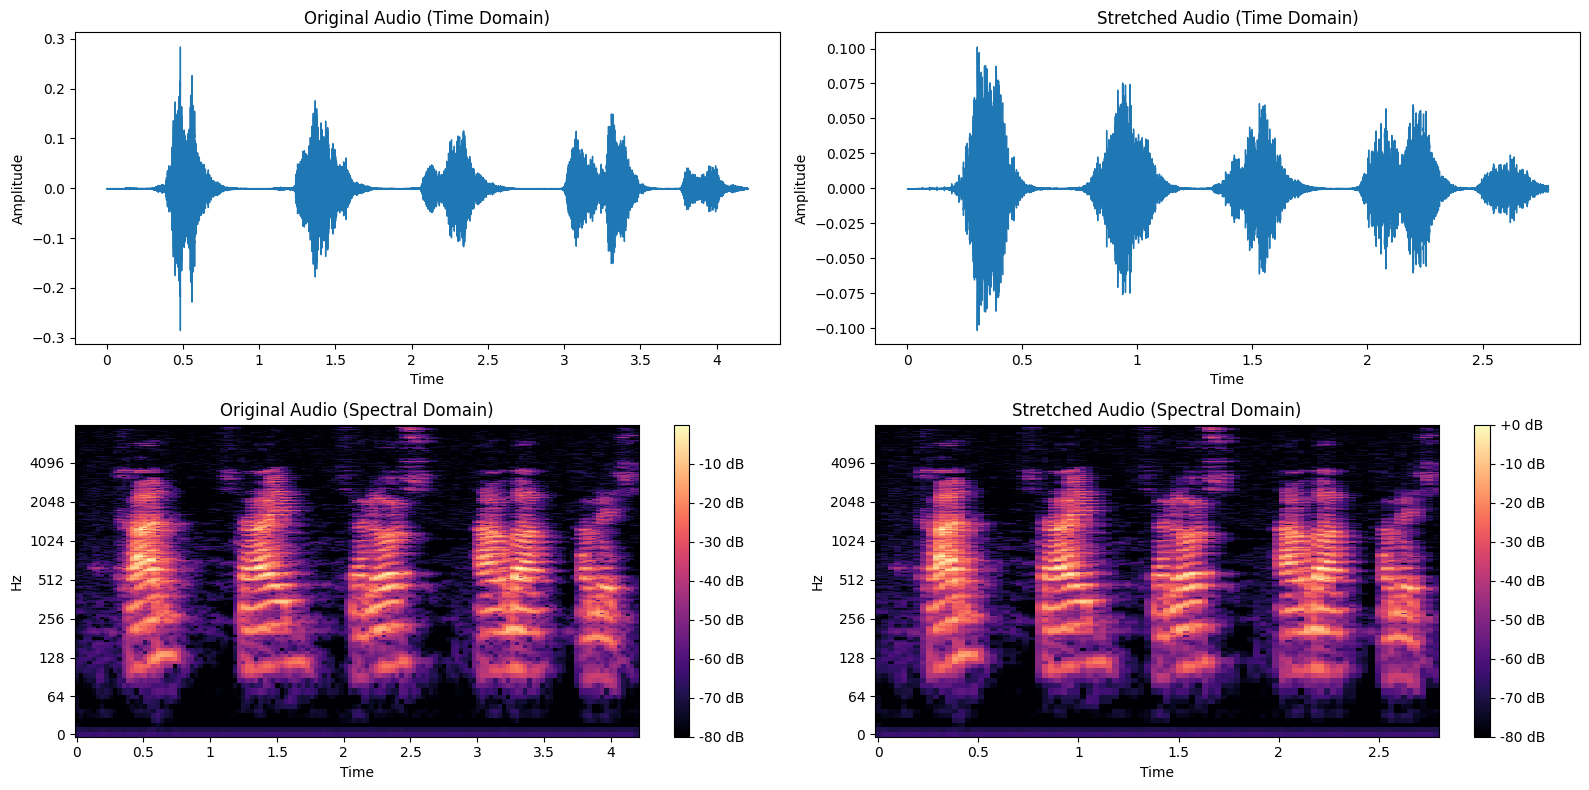

In [ ]:
# q_5

import librosa
import librosa.display as display
import numpy as np
import matplotlib.pyplot as plt


# Using the audio from Q1.c.2, increase the speed of the audio by factor of x1.5, while preserving the pitch
# Apply a time stretching algorithm using the phase vocoder.

sr = 16000
frame_length = 2048
hop_length = 512

# Load files from Q1.c.2
y5, _ = librosa.load('20CM_16k_resample.wav', sr=sr)
y6, _ = librosa.load('3M_trimmed_16k_resample.wav', sr=sr)

# i. Set the mapping between the input and output
time_stretching = 1 / 1.5

def q5(audio, time_stretching, frame_length, hop_length, sr, path, plot_path):
    # ii. Apply STFT on the audio signal
    audio_stft = librosa.stft(audio, n_fft=frame_length, hop_length=hop_length)

    # iii. Calculate the magnitude and phase values of the output
    magnitude = np.abs(audio_stft)
    phase = np.angle(audio_stft)
    number_of_freqs, num_of_segments = magnitude.shape
    number_of_stretched_segments = int(np.ceil(num_of_segments * time_stretching))
    stretched_magnitude = np.zeros((number_of_freqs, number_of_stretched_segments))
    stretched_phase = np.zeros((number_of_freqs, number_of_stretched_segments))

    # Phase vocoder algorithm
    for t_index in range(number_of_stretched_segments):
        orig_time = t_index / time_stretching

        # Identify the two closest frames in original time
        lower_frame = int(np.floor(orig_time))
        upper_frame = min(int(np.ceil(orig_time)), num_of_segments - 1)  # Cap at last frame
        interp_ratio = orig_time - lower_frame

        stretched_magnitude[:, t_index] = ((1 - interp_ratio) * magnitude[:, lower_frame] +
                                           interp_ratio * magnitude[:, upper_frame])

        if t_index > 0:
            phase_diff = phase[:, upper_frame] - phase[:, lower_frame]
            phase_diff -= 2 * np.pi * np.round(phase_diff / (2 * np.pi))
            stretched_phase[:, t_index] = stretched_phase[:, t_index - 1] + phase_diff * time_stretching

    audio_stretched_spectrogram = stretched_magnitude * np.exp(1j * stretched_phase)

    # iv. Apply iSTFT and listen to the audio
    calculated_audio = librosa.istft(audio_stretched_spectrogram, hop_length=hop_length)

    sf.write(path, calculated_audio, sr)

    # v. Plot the signals in the time domain and spectral domain

    plt.figure(figsize=(16, 8))
    plt.subplot(2, 2, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Original Audio (Time Domain)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(2, 2, 2)
    librosa.display.waveshow(calculated_audio, sr=sr)
    plt.title('Stretched Audio (Time Domain)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(2, 2, 3)
    audio_original_spec = librosa.amplitude_to_db(np.abs(librosa.stft(audio, n_fft=frame_length, hop_length=hop_length)), ref=np.max)
    librosa.display.specshow(audio_original_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original Audio (Spectral Domain)')

    plt.subplot(2, 2, 4)
    audio_stretched_spec = librosa.amplitude_to_db(np.abs(audio_stretched_spectrogram), ref=np.max)
    librosa.display.specshow(audio_stretched_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Stretched Audio (Spectral Domain)')
    plt.tight_layout()
    plt.savefig(plot_path)

q5(y5, time_stretching, frame_length, hop_length, sr, '20CM_16K_resample_stretched.wav','plot_q5_20CM_16K_resample_stretched.png')
q5(y6, time_stretching, frame_length, hop_length, sr, '3M_trimmed_16k_resample_stretched.wav','plot_q5_3M_trimmed_16k_resample_stretched.png')